In [1]:
%matplotlib inline
# For training
from keras.applications import VGG16
from keras import models, optimizers, layers
from keras.preprocessing.image import ImageDataGenerator
# Testing plugin
from livelossplot import PlotLossesKeras
from keras.utils import plot_model

import numpy as np
from tqdm import tqdm_notebook
from skimage import io

/home/sagacius/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
height = 540
width = 960
x_train = np.load("Cache/LPD/original/x_train.npy")
y_train = np.load("Cache/LPD/original/y_train.npy")
x_validation = np.load("Cache/LPD/original/x_validation.npy")
y_validation = np.load("Cache/LPD/original/y_validation.npy")
im_train = []
im_validation = []

In [3]:
for path in tqdm_notebook(x_train):
    im = io.imread(path.split("../")[1])
    im_train.append(im)
im_train = np.asarray(im_train, dtype="float16") / 255.

In [4]:
for path in tqdm_notebook(x_validation):
    im = io.imread(path.split("../")[1])
    im_validation.append(im)
im_validation = np.asarray(im_validation, dtype="float16") / 255.

In [5]:
print("[INFO] train matrix: {:.2f}MB".format(im_train.nbytes / (1024 * 1000.0)))
print("[INFO] validation matrix: {:.2f}MB".format(im_validation.nbytes / (1024 * 1000.0)))

[INFO] train matrix: 5467.50MB
[INFO] validation matrix: 2733.75MB


In [6]:
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(height, width, 3))
vgg_conv.trainable = True
#print(len(vgg_conv.trainable_weights))
set_trainable = False
for layer in vgg_conv.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
#print(len(vgg_conv.trainable_weights))
vgg_conv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 540, 960, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 540, 960, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 540, 960, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 270, 480, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 270, 480, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 270, 480, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 135, 240, 128)     0         
__________

In [7]:
model = models.Sequential()

model.add(vgg_conv)

#model.add(layers.Flatten())
#model.add(layers.Dense(256, activation='relu'))
#model.add(layers.Dense(163, activation='sigmoid'))
model.add(layers.Flatten())
model.add(layers.Dense(4, activation='sigmoid'))
plot_model(model, to_file='Logs/MMC.png')
#model.summary()

In [8]:
model.compile(loss='mean_squared_error',
              optimizer=optimizers.RMSprop(),
              metrics=['acc'])

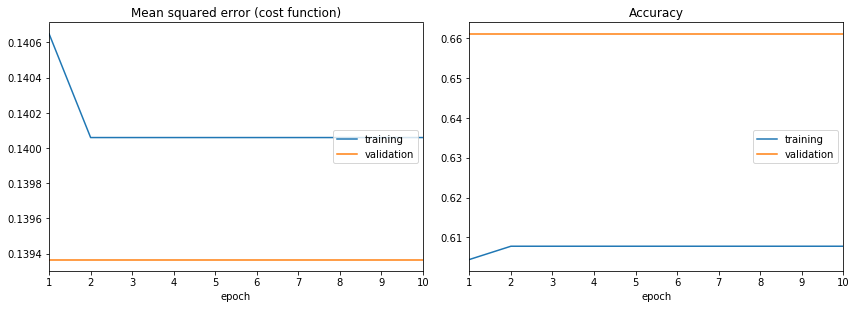

In [9]:
history = model.fit(
    im_train,
    y_train,
    batch_size=10,
    epochs=10,
    validation_data=(im_validation, y_validation),
    callbacks=[PlotLossesKeras()],
    verbose=1
)

In [10]:
model.save('Models/LD_mark2.h5')

In [11]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [12]:
nacc = np.asarray(acc)
nval_acc = np.asarray(val_acc)
nloss = np.asarray(loss)
nval_loss = np.asarray(val_loss)
logs_mark = np.row_stack((nacc, nval_acc, nloss, nval_loss))

In [13]:
print(logs_mark.shape)

(4, 10)


In [14]:
np.save("Logs/LD_mark2.npy", logs_mark)